# classification Project - Employee Turnover Prediction

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

In [199]:
X_train_csv = pd.read_csv('X_train.csv')
y_train_csv = pd.read_csv('y_train.csv')
X_test_csv = pd.read_csv('X_test.csv')

X_train_csv.drop('Unnamed: 0', axis=1, inplace=True)
X_train_csv.set_index('id', inplace=True)

X_test_csv.drop('Unnamed: 0', axis=1, inplace=True)
X_test_csv.set_index('id', inplace=True)

y_train_csv.set_index('Unnamed: 0', inplace=True)

## Pipline

In [172]:
NUM_COLS = ['JoiningYear', 'Age', 'ExperienceInCurrentDomain']
CAT_COLS = ['Education', 'City', 'PaymentTier', 'Gender', 'EverBenched', 'Race']

numeric_transformer = Pipeline(steps=[('imputer_num', SimpleImputer(strategy="mean")),
                                      ('scaler', StandardScaler())])


categorical_transformer = Pipeline(steps=[('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                          ('onehot', OneHotEncoder())])

# Combine transformers using ColumnTransformer
column_transformer = ColumnTransformer(transformers=[('num', numeric_transformer, NUM_COLS),
                                                     ('cat', categorical_transformer, CAT_COLS)])

# The final pipeline
preprocess_pipeline = Pipeline(steps=[ # ('set_id_index', func_set_index),
                                       # ('func_drop_col', func_drop_col),
                                      ('col_transformer', column_transformer)])
                                  
preprocess_pipeline

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['JoiningYear', 'Age',
                                                   'ExperienceInCurrentDomain']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Education', 'City',
                                                   'PaymentTier', 'Gender',
                                                   'EverBenched', 'Race'])]))])

## Apply SMOTE on the data

In [173]:
X_train_tts, X_test_tts, y_train_tts, y_test = train_test_split(X_train_csv, y_train_csv, train_size=0.8, random_state=0)

X_proc = column_transformer.fit_transform(X_train_tts)


one_hot_feature_names = column_transformer.named_transformers_['cat']['onehot'].get_feature_names_out(CAT_COLS)
all_feature_names = NUM_COLS + list(one_hot_feature_names)

# SMOTE
smote = SMOTE(random_state=123)
X_smote, y_smote = smote.fit_resample(X_proc, y_train_tts)

y_train = pd.DataFrame(y_smote)
X_train = pd.DataFrame(X_smote, columns=all_feature_names)

X_test_proc = column_transformer.transform(X_test_tts)
X_test = pd.DataFrame(X_test_proc, columns=all_feature_names)

In [205]:
# Clasiffiers with grid search to find the best model

def train_classifier(clf, param_grid, X_train, y_train):
    gs = GridSearchCV(clf, param_grid=param_grid, cv=10, scoring='f1')
    gs.fit(X_train, y_train)

    best_clf = gs.best_estimator_
    best_params = gs.best_params_
    best_f1_score = gs.best_score_

    print(f"Best {clf.__class__.__name__} f1 score:", best_f1_score)
    print(f"Best {clf.__class__.__name__} Parameters:", best_params)

    return best_clf, best_params, best_f1_score

In [175]:
# Confusion matrix and Classification Report function

def evaluate_and_plot(clf, X_test, y_test, class_labels):
    # Make predictions using the best estimator
    y_pred = clf.predict(X_test)

    # Evaluate the model using confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(4, 2))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:\n", class_report)

    return conf_matrix, class_report

## **Decision Tree Classifier**

In [207]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_param_grid = {'max_depth': [10, 25, 50],
                 'min_samples_leaf': [5, 10, 20],
                 'min_samples_split': [15, 20, 50]}
best_dt_clf, best_dt_params, best_dt_f1_score = train_classifier(dt_clf, dt_param_grid, X_train, y_train)

Best DecisionTreeClassifier f1 score: 0.8152222245777689
Best DecisionTreeClassifier Parameters: {'max_depth': 25, 'min_samples_leaf': 5, 'min_samples_split': 20}


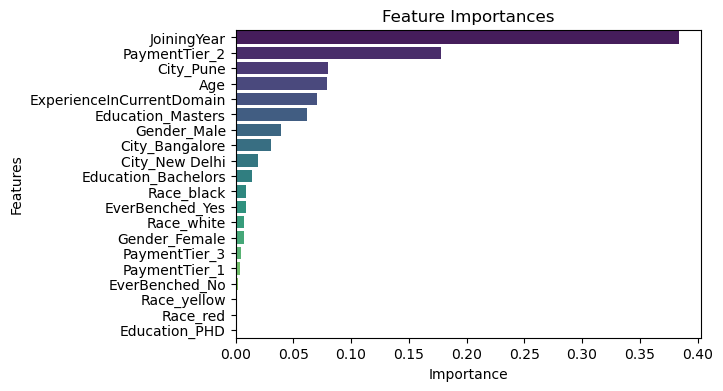

In [177]:
# DT feature importance
feature_importances = pd.Series(best_dt_clf.feature_importances_ , index=X_train.columns) 
sort_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=sort_features.values, y=sort_features.index, palette="viridis")
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

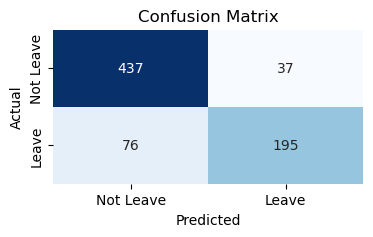

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.89       474
           1       0.84      0.72      0.78       271

    accuracy                           0.85       745
   macro avg       0.85      0.82      0.83       745
weighted avg       0.85      0.85      0.85       745



In [178]:
# Confusion matrix and Classification Report

conf_matrix_dt, class_report_dt = evaluate_and_plot(best_dt_clf, X_test, y_test, ['Not Leave', 'Leave'])

,JoiningYear,Age,ExperienceInCurrentDomain,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,PaymentTier_1,...,Gender_Male,EverBenched_No,EverBenched_Yes,Race_black,Race_red,Race_white,Race_yellow,LeaveOrNot,P(0),P(1)
0,0.495792,-0.808553,0.705485,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.866667,0.133333
1,-1.649326,-0.602750,0.705485,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.916667,0.083333
2,-0.040488,-1.014357,-0.574776,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0.000000,1.000000
3,-1.649326,-0.396946,-1.214907,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.636364,0.363636
4,0.495792,-1.425964,-1.855038,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.785714,0.214286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,-0.040488,0.014661,-0.101635,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.000000,1.000000
4826,-0.422546,-0.191143,-1.398993,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0.062500,0.937500
4827,-0.040488,-0.808553,0.689112,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0.000000,1.000000
4828,1.568351,-1.200015,-0.574776,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0.000000,1.000000


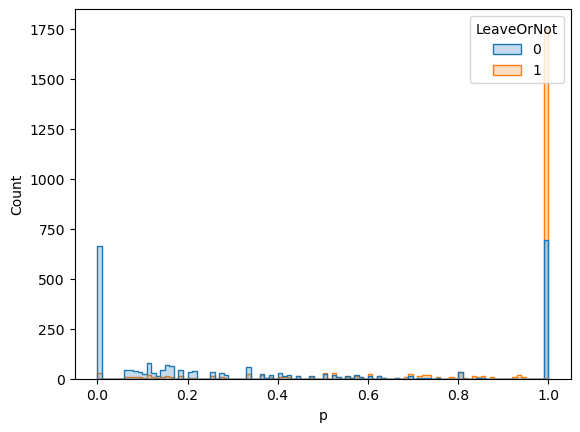

In [196]:
# Illustrative of the probability to leave or not

y_proba_dt = best_dt_clf.predict_proba(X)

leave_probs = pd.DataFrame(y_proba_dt,
                         columns=[f'P({x})' for x in best_dt_clf.classes_],
                         index=data_with_smote.index)
data_joined = data_with_smote.join(leave_probs)

df = {"p":data_joined["P(1)"].tolist(),
      "LeaveOrNot" :data_joined['LeaveOrNot']};

ax = sns.histplot(df, x="p", hue="LeaveOrNot",bins=100, element="step")
data_joined

## Ada Boost Classifier

In [ ]:
adb_clf = AdaBoostClassifier(estimator=best_dt_clf)
adb_param_grid = {'n_estimators': [10, 50, 100],
                  'learning_rate': [0.1, 0.5, 1]}
best_ada_clf, best_ada_params, best_ada_f1_score = train_classifier(adb_clf, adb_param_grid, X_train, y_train)

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

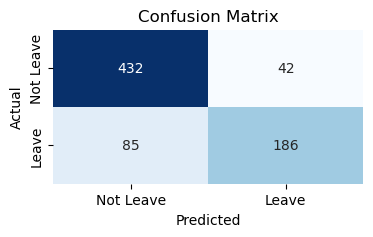

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87       474
           1       0.82      0.69      0.75       271

    accuracy                           0.83       745
   macro avg       0.83      0.80      0.81       745
weighted avg       0.83      0.83      0.83       745



In [181]:
# Confusion matrix and Classification Report

conf_matrix_adb, class_report_adb = evaluate_and_plot(best_ada_clf, X_test, y_test, ['Not Leave', 'Leave'])

## **Random Forest**

In [182]:
rf_clf = RandomForestClassifier(random_state=42)
rf_param_grid = {'n_estimators': [100, 200],
                 'max_depth': [15, 10, 25],
                 'min_samples_leaf': [20, 5, 10],
                 'min_samples_split': [10, 15, 20]}
best_rf_clf, best_rf_params, best_rf_f1_score = train_classifier(rf_clf, rf_param_grid, X_train, y_train)

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

Best RandomForestClassifier f1 score: 0.8179806463292723
Best RandomForestClassifier Parameters: {'max_depth': 25, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}


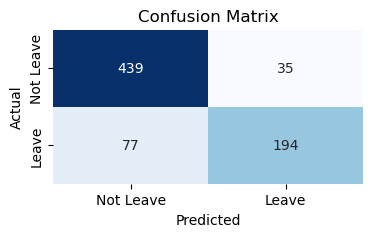

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89       474
           1       0.85      0.72      0.78       271

    accuracy                           0.85       745
   macro avg       0.85      0.82      0.83       745
weighted avg       0.85      0.85      0.85       745



In [183]:
# Confusion matrix and Classification Report

conf_matrix_rf, class_report_rf = evaluate_and_plot(best_rf_clf, X_test, y_test, ['Not Leave', 'Leave'])

## XG Boost Classifier

In [206]:
# Smaller values of "min_child_weight" allow the algorithm to create deeper trees,
# potentially capturing more intricate patterns in the training data.
# If the value is too high, the algorithm may underfit the data,
# and if it's too low, the model may become overly complex and overfit.

# gamma = minimum loss reduction required to make a further partition on a leaf node. [default=0, alias:min_splite_loss]. range: 0-There is no end. 


xgb_clf = xgb.XGBClassifier(estimator=best_dt_clf, objective="binary:hinge", random_state=42)
xgb_param_grid = {'n_estimators': [100, 200, 300],
                  'learning_rate': [0.01, 0.1, 1],
                  'max_depth': [3, 4, 5],
                  'min_child_weight': [1, 2, 6]}
#                   'gamma': [0.1, 0.2],
#                   'subsample': [0.9, 1.0],
#                   'colsample_bytree': [0.8, 0.9]   
best_xgb_clf, best_xgb_params, best_xgb_f1_score = train_classifier(xgb_clf, xgb_param_grid, X_train, y_train)

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:34:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:36:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:39:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:42:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:45:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:47:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:51:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:52:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:53:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:54:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\shaha\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [00:55:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "estimator", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
C:\User

Best XGBClassifier f1 score: 0.8486417548520396
Best XGBClassifier Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 1.0}


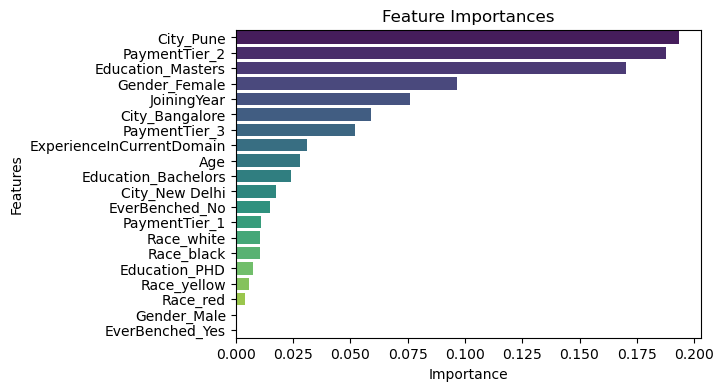

In [185]:
feature_importances = pd.Series(best_xgb_clf.feature_importances_ , index=X_train.columns) 

sort_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=sort_features.values, y=sort_features.index, palette="viridis")
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

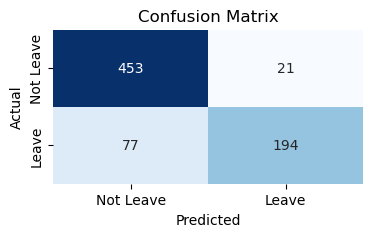

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90       474
           1       0.90      0.72      0.80       271

    accuracy                           0.87       745
   macro avg       0.88      0.84      0.85       745
weighted avg       0.87      0.87      0.86       745



In [186]:
conf_matrix_xgb, class_report_xgb = evaluate_and_plot(best_xgb_clf, X_test, y_test, ['Not Leave', 'Leave'])

## **Logistic Regression Model**

In [187]:
# # C= Regularization Strength. a large 'C' means you want a smoother curve that captures
# # the general trend without fitting each point precisely
# # tol= Tolerance for Stopping Criteria. A larger 'tol' means you're willing to stop
# # when you are reasonably close, even if you haven't found the absolute best solution.

lr_model = LogisticRegression()
lr_params_grid = {'C': [1, 5, 10],
                  'tol': [0.001, 0.0001, 0.00001]}
                  # 'penalty': ['l1', 'l2']
best_lr_clf, best_lr_params, best_lr_f1_score = train_classifier(lr_model, lr_params_grid, X_train, y_train)

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Best LogisticRegression f1 score: 0.6782158522578684
Best LogisticRegression Parameters: {'C': 5, 'tol': 0.001}


C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


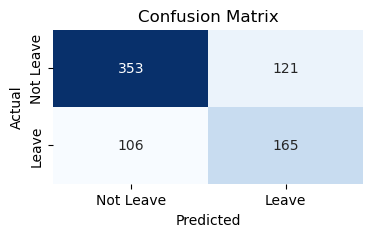

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76       474
           1       0.58      0.61      0.59       271

    accuracy                           0.70       745
   macro avg       0.67      0.68      0.67       745
weighted avg       0.70      0.70      0.70       745



In [188]:
# Confusion matrix and Classification Report

conf_matrix_lr, class_report_lr = evaluate_and_plot(best_lr_clf, X_test, y_test, ['Not Leave', 'Leave'])

## ROC - AUC

Decision Tree: 0.86
Random Forest: 0.87
Logistic Regression: 0.74
Ada Boost: 0.85
XG Boost: 0.84


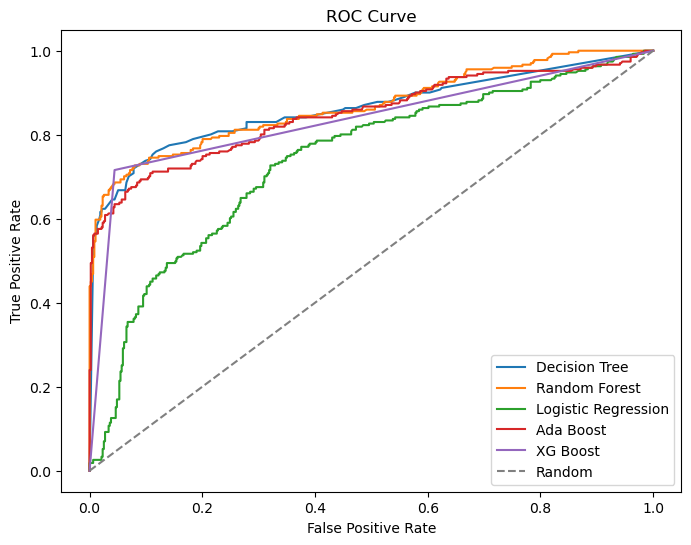

In [189]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define classifiers and their best models
classifiers = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'Ada Boost', 'XG Boost']
best_clfs = [best_dt_clf, best_rf_clf, best_lr_clf, best_ada_clf, best_xgb_clf]

# Initialize lists to store AUC values and ROC curves
auc_values = []
fpr_values = []
tpr_values = []

# Loop through classifiers
for clf, name in zip(best_clfs, classifiers):
    # Calculate predicted probabilities
    y_proba = clf.predict_proba(X_test)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_proba)
    auc_values.append(auc)

    # Calculate ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    fpr_values.append(fpr)
    tpr_values.append(tpr)

    # Print AUC evaluation
    print(f"{name}: {auc:.2f}")

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for name, fpr, tpr, auc in zip(classifiers, fpr_values, tpr_values, auc_values):
    plt.plot(fpr, tpr, label=f'{name}') #(AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Voting

In [190]:
# Soft Voting- The predicted class is the one with the highest summed probability across all classifiers.
# the classifier sums up the predicted probabilities for each class from individual classifiers and selects the class
# with the highest sum.

voting_clf = VotingClassifier(estimators= [('best_dt_clf', best_dt_clf), ('best_rf_clf', best_rf_clf)], voting= 'soft')

voting_clf.fit(X_train, y_train)

C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\shaha\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


VotingClassifier(estimators=[('best_dt_clf',
                              DecisionTreeClassifier(max_depth=25,
                                                     min_samples_leaf=5,
                                                     min_samples_split=20,
                                                     random_state=42)),
                             ('best_rf_clf',
                              RandomForestClassifier(max_depth=25,
                                                     min_samples_leaf=5,
                                                     min_samples_split=10,
                                                     random_state=42))],
                 voting='soft')

In [191]:
accuracy = voting_clf.score(X_test, y_test)
print("accuracy:", accuracy)

y_pred_vote = voting_clf.predict(X_test)

f1_votting = f1_score(y_test, y_pred_vote)
print("F1 Score:", f1_votting)

accuracy: 0.8536912751677852
F1 Score: 0.7780040733197555


## Comparing models by metrics evaluation

In [192]:
def evaluate_classifier(clf, X, y):
    y_pred = clf.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    auc = roc_auc_score(y, clf.predict_proba(X)[:, 1])

    return accuracy, precision, recall, auc

# Evaluate the models
dt_metrics = evaluate_classifier(best_dt_clf, X_test, y_test)
adb_metrics = evaluate_classifier(best_ada_clf, X_test, y_test)
rf_metrics = evaluate_classifier(best_rf_clf, X_test, y_test)
xgb_metrics = evaluate_classifier(best_xgb_clf, X_test, y_test)
lr_metrics = evaluate_classifier(best_lr_clf, X_test, y_test)


# Create a DataFrame to store the evaluation metrics
metrics_data = {
    'Classifier': ['Decision Tree', 'AdaBoost', 'Random Forest', 'XGBoost', 'Logistic Regression'],
    'F1 Score': [best_dt_f1_score, best_ada_f1_score, best_rf_f1_score, best_xgb_f1_score, best_lr_f1_score],
    'Accuracy': [dt_metrics[0], adb_metrics[0], rf_metrics[0], xgb_metrics[0], lr_metrics[0]],
    'Precision': [dt_metrics[1], adb_metrics[1], rf_metrics[1], xgb_metrics[1], lr_metrics[1]],
    'Recall': [dt_metrics[2], adb_metrics[2], rf_metrics[2], xgb_metrics[2], lr_metrics[2]],
    'AUC': [dt_metrics[3], adb_metrics[3], rf_metrics[3], xgb_metrics[3], lr_metrics[3]]
}

df_metrics = pd.DataFrame(metrics_data)

# Create a pivot table
pivot_table = df_metrics.pivot_table(index='Classifier', values=['F1 Score', 'Accuracy', 'Precision', 'Recall', 'AUC'])

# Apply color gradient to the pivot table
styled_table = pivot_table.style.background_gradient(cmap='Blues', axis=None)

# Display the colored pivot table
styled_table

,AUC,Accuracy,F1 Score,Precision,Recall
Classifier,,,,,
AdaBoost,0.848518,0.829530,0.835133,0.815789,0.686347
Decision Tree,0.861982,0.848322,0.815222,0.840517,0.719557
Logistic Regression,0.739868,0.695302,0.678216,0.576923,0.608856
Random Forest,0.868474,0.849664,0.817981,0.847162,0.715867
XGBoost,0.835782,0.868456,0.847809,0.902326,0.715867


## Submission

In [197]:
X_test_proc = column_transformer.fit_transform(X_test_csv)

one_hot_feature_names = column_transformer.named_transformers_['cat']['onehot'].get_feature_names_out(CAT_COLS)
all_feature_names = NUM_COLS + list(one_hot_feature_names)

X_test_final = pd.DataFrame(X_test_proc, columns=all_feature_names, index= X_test_csv.index)

In [198]:
final_y_pred = best_xgb_clf.predict(X_test_final)

# Create a dictionary with the predicted values {id: prediction}

prediction_dict = {id_: pred for id_, pred in zip(X_test_final.index, final_y_pred)}

# Convert NumPy int64 types to native Python int types in the dictionary (JASON requirement)
prediction_dict_converted = {int(id_): int(pred) for id_, pred in prediction_dict.items()}

import json

# convert dictionary to json file
with open('shahar_predictions.json', 'w') as f:
    json.dump(prediction_dict_converted, f)